In [1]:
#!/usr/bin/python3

import numpy as np
from sys import argv
import pyoma.browser.db as db
import pyoma.browser.models as mod
import zoo.wrappers.aligners.mafft as mafft
import zoo.wrappers.treebuilders.fasttree as fasttree
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Alphabet import IUPAC, SingleLetterAlphabet
from Bio.Seq import Seq, UnknownSeq
from Bio.SeqRecord import SeqRecord
from collections import defaultdict

from os import listdir
from os.path import isfile, join


#  for development 
import matplotlib.pyplot as plt
#import matplotlib
#matplotlib.use('Agg')

oma_database_address = "/work/FAC/FBM/DBC/cdessim2/default/smajidi1/fastoma/archive/OmaServer.h5"
project_folder = "/work/FAC/FBM/DBC/cdessim2/default/smajidi1/fastoma/v2e/f3/"


# PANPA.fa  PANPA.hogmap
# The species name of query is the name of the file; 
#  argv[2] 


In [2]:
############### Parsing OMA db ####################
###################################################

oma_db = db.Database(oma_database_address)
print("OMA data is parsed and its release name is:", oma_db.get_release_name())
list_speices= [z.uniprot_species_code for z in oma_db.tax.genomes.values()] 
print("There are",len(list_speices),"species in the OMA database.")

/work/FAC/FBM/DBC/cdessim2/default/smajidi1/software/miniconda3/lib/python3.8/site-packages/tables/leaf.py:402: PerformanceWarning: The Leaf ``/Protein/_i_Entries/OmaHOG/sorted`` is exceeding the maximum recommended rowsize (104857600 bytes);
be ready to see PyTables asking for *lots* of memory and possibly slow
I/O.  You may want to reduce the rowsize by trimming the value of
dimensions that are orthogonal (and preferably close) to the *main*
dimension of this leave.  Alternatively, in case you have specified a
very small/large chunksize, you may want to increase/decrease it.
  warnings.warn("""\


OMA data is parsed and its release name is: All.Apr2021
There are 2424 species in the OMA database.


In [3]:
############### Parsing query proteome of species #######
#########################################################

project_files = listdir(project_folder)

query_species_names = []
for file in project_files:
    if file.split(".")[-1]=="fa":
        file_name_split = file.split(".")[:-1]
        query_species_names.append('.'.join(file_name_split))

# we may assert existence of query_species_name+".fa/hogmap"

query_prot_records_species = [ ]
for query_species_name in query_species_names:
    query_prot_address = project_folder + query_species_name + ".fa" 
    query_prot_records = list(SeqIO.parse(query_prot_address, "fasta")) 
    query_prot_records_species.append(query_prot_records)
    
# for development
query_species_num = len(query_species_names)
for species_i in range(query_species_num):
    len_prot_record_i = len( query_prot_records_species[species_i] )
    species_name_i = query_species_names[species_i]
    print(species_name_i,len_prot_record_i)
    if species_name_i in list_speices: 
        print("the species",species_name_i," already exists in the oma database, remove it first")
        exit()
    

Xiphorhynchus_elegans_269412_ 5
Zosterops_hypoxanthus_2485327_ 4


In [4]:
################### Parsing omamer's output  ########
#####################################################

query_prot_names_species = []
query_hogids_species = []

for query_species_name in query_species_names:
    omamer_output_address = project_folder + query_species_name + ".hogmap"     
    omamer_output_file = open(omamer_output_address,'r');

    query_prot_names= []
    query_hogids= []

    for line in omamer_output_file:
        line_strip=line.strip()
        if not line_strip.startswith('qs'):
            line_split= line_strip.split("\t")        
            query_prot_names.append(line_split[0])
            query_hogids.append(line_split[1])
    print("number of proteins in omamer output for ",query_species_name,"is",len(query_hogids)) # ,query_hogids
    query_prot_names_species.append(query_prot_names)
    query_hogids_species.append(query_hogids)
    
#query_hogids_species# , query_prot_names_species

number of proteins in omamer output for  Xiphorhynchus_elegans_269412_ is 5
number of proteins in omamer output for  Zosterops_hypoxanthus_2485327_ is 4


In [5]:
###### Extracting unique HOG list and corresponding query proteins ########
###########################################################################

query_hogids_filtr_species = []
query_prot_names_filtr_species = []
query_prot_records_filtr_species = []

for species_i in range(query_species_num):
    print(query_species_names[species_i])
    
    query_hogids =  query_hogids_species[species_i]
    query_prot_names = query_prot_names_species[species_i]
    query_prot_records  = query_prot_records_species[species_i]
    
    
    
    query_hogids_filtr = []
    query_prot_names_filtr = []
    query_prot_records_filtr = []
    
    for prot_i in range(len(query_hogids)):
        
        if not query_hogids[prot_i] in query_hogids_filtr: 
        
            query_hogids_filtr.append(query_hogids[prot_i])
            query_prot_names_filtr.append(query_prot_names[prot_i])
            query_prot_records_filtr.append(query_prot_records[prot_i])
        else:
            # for development
            print("repeated hogid",query_hogids[prot_i], " for protein ",query_prot_names[prot_i])
            # now we keep the first protein query when these are repeated


    query_hogids_filtr_species.append(query_hogids_filtr)
    query_prot_names_filtr_species.append(query_prot_names_filtr)
    query_prot_records_filtr_species.append(query_prot_records_filtr)

    
    num_query_filtr = len(query_hogids_filtr)
    print("Number of prot queries after filtering is",num_query_filtr,"\n")

Xiphorhynchus_elegans_269412_
repeated hogid HOG:A0512899.2a  for protein  NXU82143.1
Number of prot queries after filtering is 4 

Zosterops_hypoxanthus_2485327_
Number of prot queries after filtering is 4 



In [35]:
############ Extracting the most frequent OG  ########
#####################################################

#dict (oma_group_nr -> dict(species, [proteins]))
#Og[555] = {homo_erectus: [blabla, blublu], yellow_bird: [P52134], brown_bear: [P2121,B53223]}

OGs_queries = {}


hog_OG_map = {}

mostFrequent_OG_list_species = []

frq_most_frequent_og_list_all = [] # for development

for species_i in range(query_species_num):
    
    query_species_name = query_species_names[species_i]
    print("\n",query_species_name)
    
    query_hogids_filtr = query_hogids_filtr_species[species_i]
    query_prot_names_filtr = query_prot_names_filtr_species[species_i]
    query_prot_records_filtr = query_prot_records_filtr_species[species_i]
    
    mostFrequent_OG_list=[]
    
    num_query_filtr = len(query_hogids_filtr)
    for  item_idx in range(num_query_filtr):
        
        query_protein = query_prot_names_filtr[item_idx]
        seqRecords_query =  query_prot_records_filtr[item_idx]
        seqRecords_query_edited = SeqRecord(Seq(str(seqRecords_query.seq)), query_species_name, '', '')
        #print(seqRecords_query_edited)
        
        hog_id= query_hogids_filtr[item_idx]
        
        if not hog_id in hog_OG_map:   # Caculitng  most frq OG for the new hog
            
            hog_members = oma_db.member_of_hog_id(hog_id, level = None)                  # members of the input hog_id as objects
            proteins_id_hog = [hog_member[0] for hog_member in hog_members]              # the protein IDs of hog members
            proteins_object_hog = [db.ProteinEntry(oma_db, pr) for pr in proteins_id_hog]# the protein objects of hog members
            OGs_correspond_proteins = [pr.oma_group for pr in proteins_object_hog]

            OGs_correspond_proteins_fltr = [val_og  for val_og in OGs_correspond_proteins if val_og!=0] # removing OG of 0 -those prts with no OG
            OGs_correspond_proteins_num = len(OGs_correspond_proteins_fltr)
            
            if OGs_correspond_proteins_num >0:
                mostFrequent_OG = max(set(OGs_correspond_proteins_fltr), key = OGs_correspond_proteins_fltr.count)
                
                ### for development
                
                frq_most_frequent_og = OGs_correspond_proteins_fltr.count(mostFrequent_OG)/OGs_correspond_proteins_num 
                print("For query",query_protein,"Most frequent OG is:",mostFrequent_OG, "with freq of",OGs_correspond_proteins_fltr.count(mostFrequent_OG),
                      "out of", OGs_correspond_proteins_num,"=>",round(frq_most_frequent_og,3))
                frq_most_frequent_og_list_all.append(frq_most_frequent_og)
                ### 
                
            else: # empty OGs_correspond_proteins_fltr
                mostFrequent_OG= -1
                
            hog_OG_map[hog_id]=mostFrequent_OG
                
        else:  # hog_id is in hog_OG_map dic
            print("using the hog-og-map")
            mostFrequent_OG = hog_OG_map[hog_id]
            
        if mostFrequent_OG in OGs_queries:
            OGs_queries_k = OGs_queries[mostFrequent_OG]
            
            if not query_species_name in OGs_queries_k:
                OGs_queries_k[query_species_name] = seqRecords_query_edited
                OGs_queries[mostFrequent_OG] = OGs_queries_k
        else:
            OGs_queries[mostFrequent_OG] = {query_species_name: seqRecords_query_edited} # query_protein = query_prot_names_filtr[item_idx]
            
 


 Xiphorhynchus_elegans_269412_
For query NXU82139.1 Most frequent OG is: 809610 with freq of 49 out of 59 => 0.831
For query NXU82140.1 Most frequent OG is: 823195 with freq of 6 out of 17 => 0.353
For query NXU82141.1 Most frequent OG is: 689731 with freq of 3 out of 6 => 0.5
For query NXU82142.1 Most frequent OG is: 737080 with freq of 57 out of 74 => 0.77

 Zosterops_hypoxanthus_2485327_
For query NXR29906.1 Most frequent OG is: 811933 with freq of 55 out of 57 => 0.965
For query NXR29907.1 Most frequent OG is: 950372 with freq of 114 out of 120 => 0.95
For query NXR29908.1 Most frequent OG is: 892187 with freq of 114 out of 119 => 0.958
For query NXR29909.1 Most frequent OG is: 809577 with freq of 80 out of 83 => 0.964


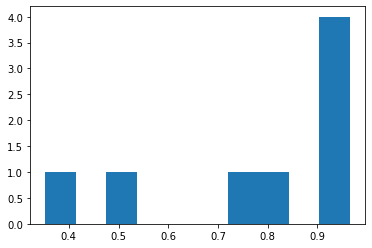

<Figure size 432x288 with 0 Axes>

In [49]:
# for development

# plots are for the last species not all 
plt.hist(frq_most_frequent_og_list_all) # , bins=10
plt.show()
plt.savefig(project_folder+"frq_most_frequent_og_list_all.png")


In [51]:
########## Combine proteins of OG with queries ##################
#################################################################

seqRecords_all = []
for OG_q in OGs_queries.keys():  # OG found in the query
    
    dic_species_prot = OGs_queries[OG_q]
    #print(dic_species_prot)
     
    seqRecords_query_edited_all = []
    for query_species_name,seqRecords_query_edited  in dic_species_prot.items():
        print(seqRecords_query_edited)
        seqRecords_query_edited_all.append(seqRecords_query_edited) 
        
    
    mostFrequent_OG = OG_q
    if mostFrequent_OG != -1:
        OG_members = oma_db.oma_group_members(mostFrequent_OG)
        proteins_object_OG = [db.ProteinEntry(oma_db, pr) for pr in OG_members]  # the protein IDs of og members
         # covnert to biopython objects
        seqRecords_OG=[SeqRecord(Seq(pr.sequence),str(pr.genome.uniprot_species_code),'','') for pr in proteins_object_OG]
        
        
        seqRecords_OG_queries =seqRecords_OG + seqRecords_query_edited_all
        #print("length of OG",mostFrequent_OG,"was",len(seqRecords_OG),",now is",len(seqRecords_OG_queries),"\n")
        
    seqRecords_all.append(seqRecords_OG_queries)
    
     
#print("number of OGs",len(seqRecords_all),len(seqRecords_OG_queries))


ID: Xiphorhynchus_elegans_269412_
Number of features: 0
Seq('ALKRFHGSSDYRREMEDIQRECFALDGEKPKKPWQLFTDRGVRWQLITVIVMTM...TYQ')
ID: Xiphorhynchus_elegans_269412_
Number of features: 0
Seq('DDDDKIVGGYTCAEHSVPYQVSLNSGYHFCGGSLISSEWVLSAAHCYKSRIQVQ...SEY')
ID: Xiphorhynchus_elegans_269412_
Number of features: 0
Seq('LQVNNNGVISFDDPVRQYTADPFPLADGGTFVAPYWADVDNVLGGDIFYRQTTD...VVG')
ID: Xiphorhynchus_elegans_269412_
Number of features: 0
Seq('QMCEKFTVCENSMEMLLQNNLNLPRVTEEDGFVNDFLTFLSFQEKCLRKISSGL...FSA')
ID: Zosterops_hypoxanthus_2485327_
Number of features: 0
Seq('AGMAQEGPPAFFGSQELDLSTKVYKRESGSPFSVLVDSKVSKGHLHEREEQQGP...YTM')
ID: Zosterops_hypoxanthus_2485327_
Number of features: 0
Seq('VEYMLVKFDHENKKVRLILCGEEIVQTLQDKGEKVNPNHPTLWRPEYGSYMIEG...TDS')
ID: Zosterops_hypoxanthus_2485327_
Number of features: 0
Seq('MAPKKKNVKKNKADINETTIIVEDGPLSKLNGLNGLLEGGNGFSCISSEVSDPS...VSI')
ID: Zosterops_hypoxanthus_2485327_
Number of features: 0
Seq('MNRYKTIRQLGDGTYGSVLLGRSIESGELIAIKKMKRKFYSWEECMNLREVKSL...AHR')


In [53]:
# # for development
# # plots are for the last species not all 
# plt.hist(seqRecords_OG_num_list) # , bins=10
# plt.show()
# plt.savefig(project_folder+"_one_species_seqRecords_OG_num_list.png")


In [54]:
############## MSA  ##############
##################################


result_mafft_all_species = []
for seqRecords_OG_queries in seqRecords_all:
    print(len(seqRecords_OG_queries))
    #print("MSA on progress for og ", ?)
    wrapper_mafft = mafft.Mafft(seqRecords_OG_queries,datatype="PROTEIN")
    run_mafft = wrapper_mafft()
    time_taken_mafft = wrapper_mafft.elapsed_time

    result_mafft = wrapper_mafft.result   
    time_taken_mafft2 = wrapper_mafft.elapsed_time
    print("time elapsed for MSA: ",time_taken_mafft2)

    result_mafft_all_species.append(result_mafft)
    print(len(result_mafft),result_mafft.get_alignment_length()) # matrix size

        
print(result_mafft_all_species)

127
time elapsed for MSA:  38.32399821281433
127 979
40
time elapsed for MSA:  0.8300786018371582
40 274
25
time elapsed for MSA:  0.8590226173400879
25 470
63
time elapsed for MSA:  1.9365646839141846
63 280
87
time elapsed for MSA:  16.405167818069458
87 872
401
time elapsed for MSA:  83.65566611289978
401 2701
115
time elapsed for MSA:  29.59513521194458
115 730
106
time elapsed for MSA:  29.90656590461731
106 936
[<<class 'Bio.Align.MultipleSeqAlignment'> instance (127 records of length 979, SingleLetterAlphabet()) at 7efe80834070>, <<class 'Bio.Align.MultipleSeqAlignment'> instance (40 records of length 274, SingleLetterAlphabet()) at 7efe80834af0>, <<class 'Bio.Align.MultipleSeqAlignment'> instance (25 records of length 470, SingleLetterAlphabet()) at 7efe876fc130>, <<class 'Bio.Align.MultipleSeqAlignment'> instance (63 records of length 280, SingleLetterAlphabet()) at 7efe807f8850>, <<class 'Bio.Align.MultipleSeqAlignment'> instance (87 records of length 872, SingleLetterAlphabe

In [55]:
############## Concatante alignments  ##############
####################################################

#alignments= result_maf2_all

alignments= result_mafft_all_species
print("alignments len",len(alignments))
#print([len(aln) for aln in alignments ])
#print([len(seq) for aln in alignments for seq in aln])

all_labels_raw = [seq.id for aln in alignments for seq in aln]
all_labels = set(all_labels_raw)
print("ids: ",len(all_labels),len(all_labels_raw))

# Make a dictionary to store info as we go along
# (defaultdict is convenient -- asking for a missing key gives back an empty list)
concat_buf = defaultdict(list)

# Assume all alignments have same alphabet
alphabet = alignments[0]._alphabet

for aln in alignments:
    length = aln.get_alignment_length()
    #print("length",length)
    # check if any labels are missing in the current alignment
    these_labels = set(rec.id for rec in aln)
    missing = all_labels - these_labels
    #print(missing)
    # if any are missing, create unknown data of the right length,
    # stuff the string representation into the concat_buf dict
    for label in missing:
        new_seq = UnknownSeq(length, alphabet=alphabet)
        concat_buf[label].append(str(new_seq))

    # else stuff the string representation into the concat_buf dict
    for rec in aln:
        concat_buf[rec.id].append(str(rec.seq))

# Stitch all the substrings together using join (most efficient way),
# and build the Biopython data structures Seq, SeqRecord and MultipleSeqAlignment
msa = MultipleSeqAlignment(SeqRecord(Seq(''.join(seq_arr), alphabet=alphabet), id=label)
                            for (label, seq_arr) in concat_buf.items())

#print(msa)

alignments len 8
ids:  441 964


In [56]:


out_name_msa=project_folder+"_msa_concatanated.txt"
handle_msa_fasta = open(out_name_msa,"w")
SeqIO.write(msa, handle_msa_fasta,"fasta")
handle_msa_fasta.close()
    
print(len(msa),msa.get_alignment_length()) # super matrix size

441 7242


In [57]:
############## Tree inference  ###################
##################################################

wrapper_tree=fasttree.Fasttree(msa,datatype="PROTEIN")
result_tree1 = wrapper_tree()

time_taken_tree = wrapper_tree.elapsed_time 
time_taken_tree

result_tree2 = wrapper_tree.result
tree_nwk=str(result_tree2["tree"])
print(len(tree_nwk))

out_name_tree=project_folder+"_tree.txt"
file1 = open(out_name_tree,"w")
file1.write(tree_nwk)
file1.close() 

15871


In [58]:
tree_nwk

'((CHLSB:0.004565817,((COLAP:0.002831449,(RHIBE:0.003608682,RHIRO:0.001034256)0.986:0.002688817)0.955:0.00177094,(PONAB:0.008433743,(NOMLE:0.011892459,((GORGO:0.004606416,((PANTR:0.000514131,PANPA:0.000500607)0.995:0.003011685,HUMAN:0.002654588)0.637:0.000210703)0.950:0.001405154,(((((MICMU:0.02498245,PROCO:0.015580076)0.998:0.01631916,OTOGA:0.076407306)1.000:0.023696829,((((((MYOLU:0.075709908,PTEVA:0.018181968)0.982:0.012019736,((FELCA:0.037274162,((CANLF:0.015419662,VULVU:0.008315328)1.000:0.027032995,(MUSPF:0.045042408,(AILME:0.011177043,(URSAM:0.001751395,URSMA:0.004062977)0.978:0.004898445)1.000:0.010344481)0.999:0.009009099)0.936:0.004632387)0.981:0.014492175,ERIEU:0.130850093)0.189:0.004910443)0.745:0.001819222,SORAR:0.088590045)0.532:0.001413274,((MANJA:0.07723967,((PIGXX:0.035986961,(TURTR:0.020415423,(BOVIN:0.007218944,(CAPHI:0.011562634,SHEEP:0.016459896)0.912:0.004178717)1.000:0.050429924)0.987:0.006255351)0.008:0.003043479,VICPA:0.033701779)0.998:0.019180828)0.310:0.00504